# Linear Regression 2 ways

We are all familiar with linear regression.  There are numerous ways to solve the problem.

Essentially, the best fit line thru a set of points is the one that has lowest MSE (mean squared error) of the residuals.  

## sample data

In [1]:
from io import StringIO
import pandas
import statsmodels.api as sm
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
df = pandas.read_csv(StringIO("year,GDP,sales\n2011,6.2,26.3\n2012,6.5,26.65\n2013,5.48,25.03\n2014,6.54,26.01\n2015,7.18,27.9\n2016,7.93,30.47"))
df

,year,GDP,sales
0,2011,6.20,26.30
1,2012,6.50,26.65
2,2013,5.48,25.03
3,2014,6.54,26.01
4,2015,7.18,27.90
5,2016,7.93,30.47


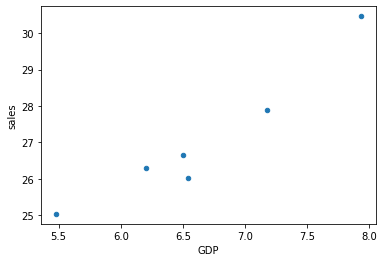

In [3]:
df.plot(x='GDP', y='sales', kind='scatter')

## regression using OLS (ordinary least squares) method

the OLS method is based on linear algebra and matrix inversions

In [4]:
# use OLS to find best fit line
X = df.GDP
model = sm.OLS(df.sales, X).fit()

# summarize our model
summary = model.summary()
summary

/usr/local/lib/python3.7/dist-packages/statsmodels/stats/stattools.py:71: ValueWarning: omni_normtest is not valid with less than 8 observations; 6 samples were given.
  "samples were given." % int(n), ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  sales   R-squared (uncentered):                   0.997
Model:                            OLS   Adj. R-squared (uncentered):              0.996
Method:                 Least Squares   F-statistic:                              1583.
Date:                Tue, 15 Jun 2021   Prob (F-statistic):                    1.89e-07
Time:                        02:20:40   Log-Likelihood:                         -11.032
No. Observations:                   6   AIC:                                      24.06
Df Residuals:                       5   BIC:                                      23.86
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
GDP            4.0515      0.102     39.785      0.000       3.790       4.313
==============================================================================
Omnibus:                          nan   Durbin-Watson:                   1.350
Prob(Omnibus):                    nan   Jarque-Bera (JB):                0.489
Skew:                           0.535   Prob(JB):                        0.783
Kurtosis:                       2.099   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [5]:
sales_predict = model.predict(X)
df['sales_predict'] = sales_predict # add to data frame
df


,year,GDP,sales,sales_predict
0,2011,6.20,26.30,25.119030
1,2012,6.50,26.65,26.334467
2,2013,5.48,25.03,22.201982
3,2014,6.54,26.01,26.496525
4,2015,7.18,27.90,29.089458
5,2016,7.93,30.47,32.128050


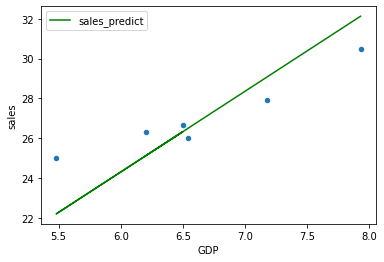

In [6]:
ax = df.plot(x='GDP', y='sales', kind='scatter')
# predicted data
df.plot(x='GDP', y='sales_predict', ax=ax, color='green')


In [7]:
# verify linear equation ... y = mx+b
m = model.params['GDP']
b = 0
print(m) 
m * df.GDP  + b

4.051456484975701


0    25.119030
1    26.334467
2    22.201982
3    26.496525
4    29.089458
5    32.128050
Name: GDP, dtype: float64

In [8]:
# try again w/ intercept - not obvious how to do this w/ statsmodels

X = sm.add_constant(df.GDP)
model = sm.OLS(df.sales, X).fit()

sales_predict = model.predict(X)
df['sales_predict'] = sales_predict # add to data frame
df

# summarize our model
summary = model.summary()
summary

/usr/local/lib/python3.7/dist-packages/statsmodels/stats/stattools.py:71: ValueWarning: omni_normtest is not valid with less than 8 observations; 6 samples were given.
  "samples were given." % int(n), ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  sales   R-squared:                       0.920
Model:                            OLS   Adj. R-squared:                  0.900
Method:                 Least Squares   F-statistic:                     46.06
Date:                Tue, 15 Jun 2021   Prob (F-statistic):            0.00246
Time:                        02:20:56   Log-Likelihood:                -4.2789
No. Observations:                   6   AIC:                             12.56
Df Residuals:                       4   BIC:                             12.14
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         12.5494      2.152      5.831      0.004       6.574      18.525
GDP            2.1859      0.322      6.787      0.002       1.292       3.080
==============================================================================
Omnibus:                          nan   Durbin-Watson:                   2.297
Prob(Omnibus):                    nan   Jarque-Bera (JB):                0.452
Skew:                          -0.399   Prob(JB):                        0.798
Kurtosis:                       1.918   Cond. No.                         59.6
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

2.185880672817289 12.549395466947885


0    26.101856
1    26.757620
2    24.528022
3    26.845055
4    28.244019
5    29.883429
Name: GDP, dtype: float64

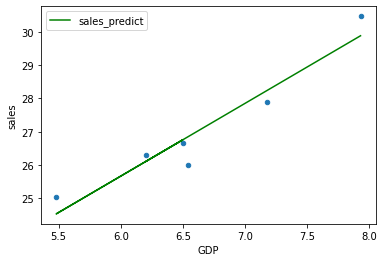

In [9]:
# verify linear equation ... y = mx+b
m = model.params['GDP']
b = model.params['const']

print (m,b)

ax = df.plot(x='GDP', y='sales', kind='scatter')
# predicted data
df.plot(x='GDP', y='sales_predict', ax=ax, color='green')


m * df.GDP  + b

## gradient descent to estimate regression parameters

General procedure
- define a Cost function
- find the minimum of the Cost function
- find minimum by "descending down the maximum slope" until you "reach the bottom"

In [10]:
def cost_function(df, xcol, ycol, m, b):
    # just RMSE for now

    y_pred = m*df[xcol] + b
    return np.sqrt(sum((df[ycol] - y_pred) ** 2))

def cost_function_meshgrid(df, xcol, ycol, m, b):
    y_pred = 0
    cost = 0
    for ii,rr in df.iterrows():
        y_pred += m*rr[xcol] + b
    for ii,rr in df.iterrows():
        cost += (rr[ycol] - y_pred) ** 2
    
    return np.sqrt(cost)
    

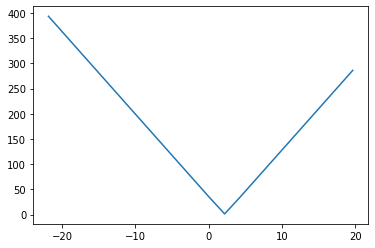

In [11]:
# plot rmse vs different m to verify that OLS gave right answer
m_range = np.arange(-10, 10, 1) * m 
rmse_range = list()
for mm in m_range:
    rmse_range.append(cost_function(df, 'GDP', 'sales', mm,b))
plt.plot(m_range, rmse_range)

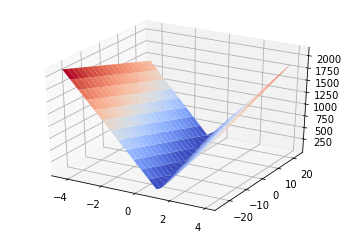

In [12]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np

m_range = np.arange(-10, 10, 1) * m / 5.
b_range = np.arange(-10, 10, 1) * b / 5.
mm, bb = np.meshgrid(m_range, b_range)


zz = cost_function_meshgrid(df, 'sales', 'GDP', mm,bb)
fig = plt.figure()
ax = fig.gca(projection='3d')

h = ax.plot_surface(mm,bb,zz, cmap=cm.coolwarm)

In [14]:
def compute_error_for_line_given_points(b,m,points):
    totalError = 0 	#sum of square error formula
    for i in range (0, len(points)):
        x = points[i, 0]
        y = points[i, 1]
        totalError += (y-(m*x + b)) ** 2
    return np.sqrt(totalError)#/ float(len(points))

def step_gradient(b_current, m_current, points, learning_rate):
	#gradient descent
	b_gradient = 0
	m_gradient = 0
	N = float(len(points))
	for i in range(0, len(points)):
		x = points[i, 0]
		y = points[i, 1]
		b_gradient += -(2/N) * (y - (m_current * x + b_current))
		m_gradient += -(2/N) * x * (y - (m_current * x + b_current))
	new_b = b_current - (learning_rate * b_gradient)
	new_m = m_current - (learning_rate * m_gradient) 
	return [new_b,new_m]

In [15]:
def gradient_descent_runner(points, starting_b, starting_m, learning_rate, num_iterations):
	b = starting_b
	m = starting_m
	for i in range(num_iterations):
		b,m = step_gradient(b, m, np.array(points), learning_rate)
	return [b,m]

In [16]:
df['ones'] = 1

In [17]:
points = df[['GDP', 'sales']].values
points

array([[ 6.2 , 26.3 ],
       [ 6.5 , 26.65],
       [ 5.48, 25.03],
       [ 6.54, 26.01],
       [ 7.18, 27.9 ],
       [ 7.93, 30.47]])

In [42]:
#points = genfromtxt('data.csv', delimiter=',')


learning_rate = 0.0001 #how fast the data converge

initial_b = 12 # initial y-intercept guess
initial_m = 2 # initial slope guess
num_iterations = 300

[b, m] = gradient_descent_runner(points, initial_b, initial_m, learning_rate, num_iterations)
print("After {0} iterations b = {1}, m = {2}, error = {3}".format(num_iterations, b, m, compute_error_for_line_given_points(b, m, points)))

After 3000 iterations b = nan, m = nan, error = nan


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: overflow encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in double_scalars


In [43]:
print(m,b)
df['predict_ml'] = m * df.GDP + b

nan nan


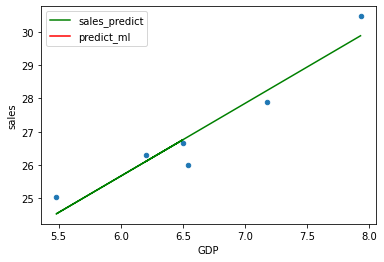

In [44]:
ax = df.plot(x='GDP', y='sales', kind='scatter')
df.plot(x='GDP', y='sales_predict', ax=ax, color='green') # predicted data
df.plot(x='GDP', y='predict_ml', ax=ax, color='red') # predicted data